In [1]:
import numpy as np
from spec_id import Scale_model, Cluster, Cluster_model,Cluster_fit_sim, Cluster_fit_sim_MC
import matplotlib.pyplot as plt
from vtl.Readfile import Readfile
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [19]:
def Mgb_Fe(wv, fl):
    ######Interpolate spec######
    waves=np.linspace(5000,5500,1000)
    sed=interp1d(wv,fl)(waves)

    ######Define Lick indices#####
    mgb = np.array([5160.125, 5192.625])
    mgcont=np.array([[5142.625, 5161.375],[5191.375,5206.375]])
    fe5270 = np.array([5245.650, 5285.650])
    fe5270cont=np.array([[5233.150, 5248.150],[5285.65,5318.15]])
    fe5335 = np.array([5312.125, 5352.125])
    fe5335cont=np.array([[5304.625, 5315.875],[5353.375,5363.375]])

    #######setup arrays for regions#####
    contspecmg = [[],[]]
    contwavemg = [[],[]]
    contspecfe5270 = [[],[]]
    contwavefe5270 = [[],[]]
    contspecfe5335 = [[],[]]
    contwavefe5335 = [[],[]]
    mgwave,mgspec = [[],[]]
    fe5270wave,fe5270spec = [[],[]]
    fe5335wave,fe5335spec = [[],[]]

    ########Define regions and find continua#######
    for i in range(len(sed)):
        if mgb[0] <= waves[i] <= mgb[1]:
            mgwave.append(waves[i])
            mgspec.append(sed[i])
        if fe5270[0] <= waves[i] <= fe5270[1]:
            fe5270wave.append(waves[i])
            fe5270spec.append(sed[i])
        if fe5335[0] <= waves[i] <= fe5335[1]:
            fe5335wave.append(waves[i])
            fe5335spec.append(sed[i])

        if mgcont[0][0] <= waves[i] <= mgcont[0][1]:
            contspecmg[0].append(sed[i])
            contwavemg[0].append(waves[i])
        if mgcont[1][0] <= waves[i] <= mgcont[1][1]:
            contspecmg[1].append(sed[i])
            contwavemg[1].append(waves[i])

        if fe5270cont[0][0] <= waves[i] <= fe5270cont[0][1]:
            contspecfe5270[0].append(sed[i])
            contwavefe5270[0].append(waves[i])
        if fe5270cont[1][0] <= waves[i] <= fe5270cont[1][1]:
            contspecfe5270[1].append(sed[i])
            contwavefe5270[1].append(waves[i])

        if fe5335cont[0][0] <= waves[i] <= fe5335cont[0][1]:
            contspecfe5335[0].append(sed[i])
            contwavefe5335[0].append(waves[i])
        if fe5335cont[1][0] <= waves[i] <= fe5335cont[1][1]:
            contspecfe5335[1].append(sed[i])
            contwavefe5335[1].append(waves[i])

    ######Find the mean of the continua########
    cont_linemg = [1/(contwavemg[0][-1]-contwavemg[0][0])*np.trapz(contspecmg[0],contwavemg[0])
        ,1/(contwavemg[1][-1]-contwavemg[1][0])*np.trapz(contspecmg[1],contwavemg[1])]
    cont_linefe5270 = [1/(contwavefe5270[0][-1]-contwavefe5270[0][0])*np.trapz(contspecfe5270[0],contwavefe5270[0])
        ,1/(contwavefe5270[1][-1]-contwavefe5270[1][0])*np.trapz(contspecfe5270[1],contwavefe5270[1])]
    cont_linefe5335 = [1/(contwavefe5335[0][-1]-contwavefe5335[0][0])*np.trapz(contspecfe5335[0],contwavefe5335[0])
        ,1/(contwavefe5335[1][-1]-contwavefe5335[1][0])*np.trapz(contspecfe5335[1],contwavefe5335[1])]
    cont_wavemg=[np.mean(contwavemg[0]),np.mean(contwavemg[1])]
    cont_wavefe5270=[np.mean(contwavefe5270[0]),np.mean(contwavefe5270[1])]
    cont_wavefe5335=[np.mean(contwavefe5335[0]),np.mean(contwavefe5335[1])]

    #######interpolate regions for final analysis########
    icontmg=interp1d(cont_wavemg,cont_linemg)
    icontfe5270=interp1d(cont_wavefe5270,cont_linefe5270)
    icontfe5335=interp1d(cont_wavefe5335,cont_linefe5335)

    ########Fing EWs##########
    Mgb=np.trapz((1-mgspec/icontmg(mgwave)),mgwave)
    Fe5270=np.trapz((1-fe5270spec/icontfe5270(fe5270wave)),fe5270wave)
    Fe5335=np.trapz((1-fe5335spec/icontfe5335(fe5335wave)),fe5335wave)

    #####plot check######
    plt.plot(waves, sed)
    plt.plot(mgwave,mgspec)
    plt.plot(cont_wavemg,cont_linemg)

    plt.plot(fe5270wave, fe5270spec)
    plt.plot(cont_wavefe5270, cont_linefe5270)

    plt.plot(fe5335wave, fe5335spec)
    plt.plot(cont_wavefe5335, cont_linefe5335)

    plt.xlim(4000, 5500)
    plt.show()

    # print Mgb
    # print Fe5270
    # print Fe5335

    ########Calculate [Mgb/Fe]##########
    mgfe=np.sqrt(Mgb*(0.72*Fe5270+0.28*Fe5335))

    return mgfe

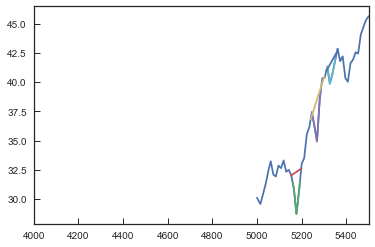

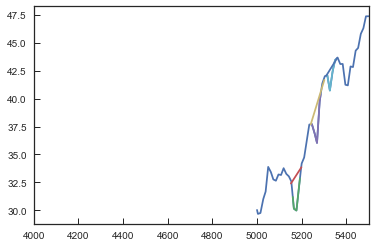

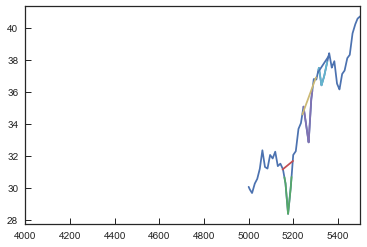

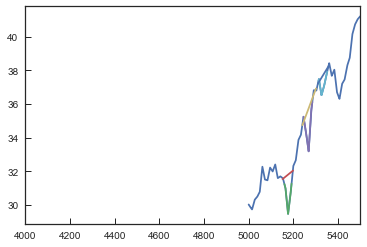

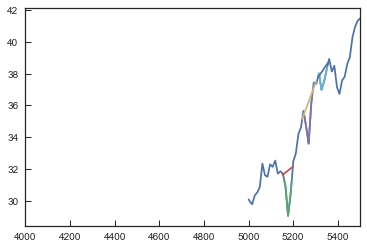

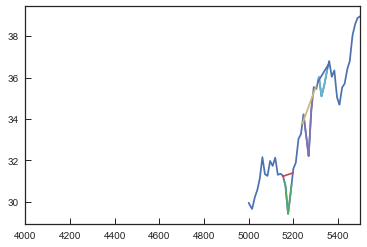

In [25]:
%matplotlib inline
mfits = 10**np.array([-0.1, -0.2, -0.64, -0.65, -0.66, -0.68])
mgbg = np.zeros(len(mfits))
nc_mgb = np.zeros(len(mfits))
cluster=[6528,6553,5927,6441,6304,6388]

for i in range(len(cluster)):
    ngc=Cluster('../clusters/ngc%s_griz_err_1.1.npy' % cluster[i] ,1.1)
    ngc.Remove_continuum()
    mgbg[i] = Mgb_Fe(ngc.wv/(1+ngc.redshift),ngc.fl)
    # nc_mgb[i] = Mgb_Fe(ngc.nc_wv, ngc.nc_fl)

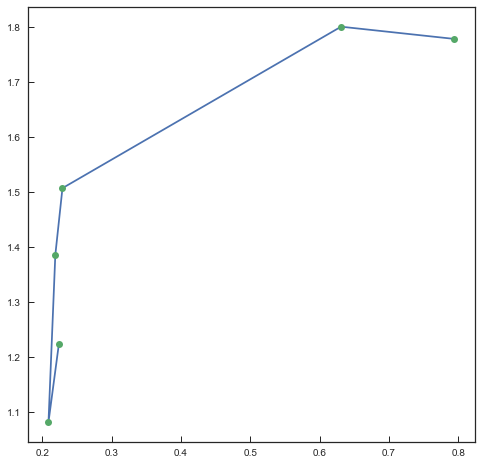

In [17]:
plt.figure(figsize=[8,8])
plt.plot(mfits,mgb)
plt.plot(mfits,mgb,'o')
plt.show()
plt.close()

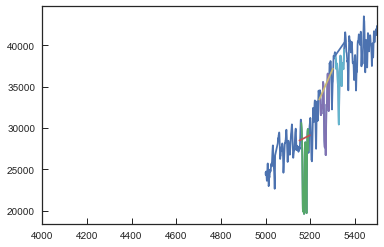

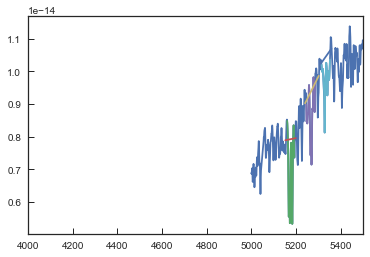

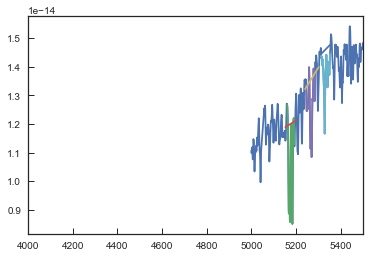

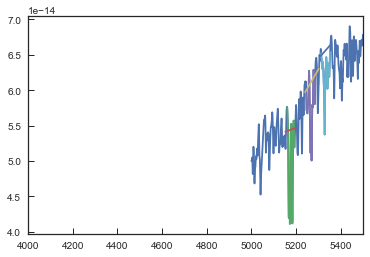

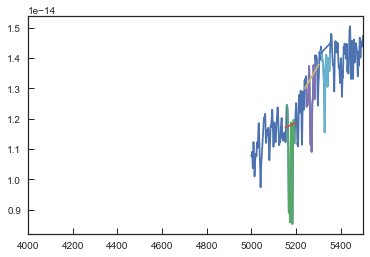

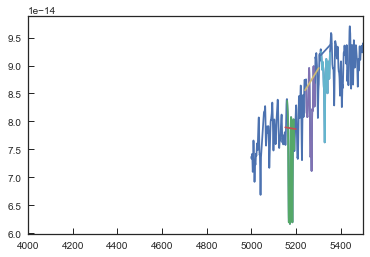

In [26]:
%matplotlib inline
mfits = 10**np.array([-0.1, -0.2, -0.64, -0.65, -0.66, -0.68])
mgb = np.zeros(len(mfits))
nc_mgb = np.zeros(len(mfits))
cluster=[6528,6553,5927,6441,6304,6388]

for i in range(len(cluster)):
    wv,fl=Readfile('../clusters/ngc%s_spec.dat' % cluster[i])
    mgb[i] = Mgb_Fe(wv,fl)

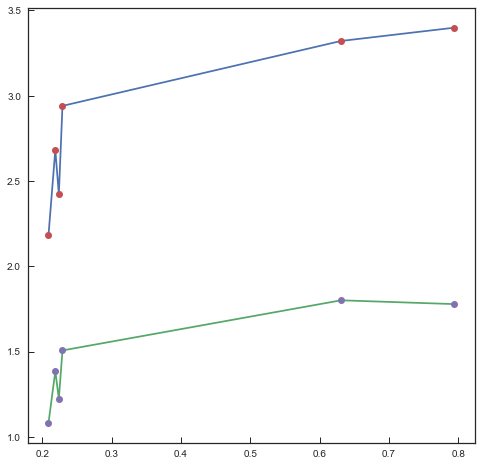

In [32]:
plt.figure(figsize=[8,8])
plt.plot(mfits,mgb)
plt.plot(mfits,mgbg)
plt.plot(mfits,mgb,'o')
plt.plot(mfits,mgbg,'o')
plt.show()
plt.close()